## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [2]:
# pandas and numpy

import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

import nltk #to add words to stop words
import re
import string

# textblob
from textblob import TextBlob

# model preparation
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#set seed
import random
random.seed(10)

#word clouds
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#topic modeling
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
#import file 
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


In [4]:
#check the size of the dataset
print("Shape of current df:", congress_tweets.shape)

Shape of current df: (946791, 16)


In [5]:
#subset the data
## chose 1% of tweets because full data set was computationally expensive 
congress_tweets = congress_tweets.sample(frac=0.01, random_state=1)
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9468, 16)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
217331,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. http...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"
258764,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688"
50091,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744"
205601,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"
85993,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958"


In [6]:
#reset index
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index(drop = True)  #remove missing values
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9468, 16)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. http...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"
1,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688"
2,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744"
3,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"
4,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958"


In [7]:
#text data
congress_tweets['text'].head(15)

0     Thank you for testifying today Mr. Blake. http...
1     My Twitter Town Hall on healthcare has begun a...
2     Scipio Jones‘ fight for civil rights and equal...
3     There is no better time to #ActOnClimate than ...
4     I understand the VA often has problems recruit...
5     RT @Johnson4Dallas This is the most accurate d...
6     Instead of solving the problem with us, the Pr...
7     RT @HouseGOP The House is voting on legislatio...
8     If this is what he calls "winning" then yes, I...
9     That common sense approach is needed now, more...
10    RT @repblumenauer As I told the @NYTimes, it's...
11    RT @RepMcEachin Today @SenDuckworth, @SenBooke...
12    On #MLKDay, we reflect on the unique strength,...
13    Iran &amp; Russia, as expected, are trying to ...
14    Today I joined @SecretaryCarson's site visit t...
Name: text, dtype: object

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [8]:
#replace all two independents as democrats 
congress_tweets['party']=congress_tweets['party'].replace(r"Independent", "Democrat", regex=True)

In [9]:
#Remove emojis
def rem_emoji(text):
    emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002500-\U00002BEF"  # chinese char
                            u"\U00002702-\U000027B0"
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            u"\U0001f926-\U0001f937"
                            u"\U00010000-\U0010ffff"
                            u"\u2640-\u2642" 
                            u"\u2600-\u2B55"
                            u"\u200d"
                            u"\u23cf"
                            u"\u23e9"
                            u"\u231a"
                            u"\ufe0f"  # dingbats
                            u"\u3030"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#passing the emoji function to 'text'
congress_tweets['text'] = congress_tweets['text'].apply(rem_emoji)

In [10]:
#Remove line breaks 
def rem_lbreaks(text):
    line_breaks = re.compile('\n')
    return line_breaks.sub(r'', text)

#passing line function to 'text'
congress_tweets['text'] = congress_tweets['text'].apply(rem_lbreaks)

In [11]:
#Remove urls
def rem_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

#passing urls function to 'text' 
congress_tweets['text'] = congress_tweets['text'].apply(rem_urls)

In [12]:
#create rem_punc_stop() function
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    nlp.Defaults.stop_words.add("rt") 
    nlp.Defaults.stop_words.add("qt") 
    nlp.Defaults.stop_words.add("amp") 
    nlp.Defaults.stop_words.add("need") # to get rid of the word "need" because it is large on all wordclouds
    nlp.Defaults.stop_words.add("today") # to get rid of the word "today" because it is large on all wordclouds
    nlp.Defaults.stop_words.add("thank") # to get rid of the word "thank" because it is large on all wordclouds
    
    punc = set(punctuation)
    punc.update(['–','“',"‘",'¯','1⃣']) # add additional symbols
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    #create tokens
    spacy_words = [token.text.lower() for token in doc] #to make the text all lower case 

    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc


In [13]:
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index(drop = True)  #remove missing values

In [14]:
# apply rem_punc_stop function to every row of our dataframe
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x)) # x = each item in the 'text'
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9468, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. QT ...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[testifying, mr, blake, , jrblake, repvaldemi..."
1,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688","[twitter, town, hall, healthcare, begun, m, an..."
2,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744","[scipio, jones, fight, civil, rights, equality..."
3,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[better, time, actonclimate, earthday, role, p..."
4,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[understand, va, problems, recruiting, qualifi..."


In [15]:
#Remove blank spaces
def rem_spaces(text):
    text = [item.strip(' ') for item in text]  #removes white spaces in each item
    return [item for item in text if item]  #removes items that are empty strings

#Passing function to 'tokens'
congress_tweets['tokens'] = congress_tweets['tokens'].apply(rem_spaces)
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9468, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. QT ...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[testifying, mr, blake, jrblake, repvaldemings..."
1,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688","[twitter, town, hall, healthcare, begun, m, an..."
2,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744","[scipio, jones, fight, civil, rights, equality..."
3,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[better, time, actonclimate, earthday, role, p..."
4,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[understand, va, problems, recruiting, qualifi..."


In [16]:
#Remove tweets with no words 
congress_tweets = congress_tweets[congress_tweets['tokens'].map(lambda x: len(x) > 0)].reset_index(drop = True)
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9427, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. QT ...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[testifying, mr, blake, jrblake, repvaldemings..."
1,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688","[twitter, town, hall, healthcare, begun, m, an..."
2,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744","[scipio, jones, fight, civil, rights, equality..."
3,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[better, time, actonclimate, earthday, role, p..."
4,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[understand, va, problems, recruiting, qualifi..."


In [17]:
congress_tweets['tokens'][0] # text string -> tokens in list form -- no spaces, emojis, urls, or other punctuation

['testifying',
 'mr',
 'blake',
 'jrblake',
 'repvaldemings',
 'gave',
 'impassioned',
 'speech',
 'place',
 'experience',
 'having',
 'served',
 '27',
 'years',
 'police',
 'force']

In [18]:
#check the length of smallest tweet
congress_tweets['tokens'].str.len().min()

1

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

## EDA 1. WordClouds

In [19]:
# initialize wordcloud data and function

# Convert list of tokens back to text string
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text) #wordcloud library

In [20]:
# create a dictionary of word frequencies

text_dictionary = wordcloud.process_text(text)
# sort the dictionary
word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}

#use words_ to print relative word frequencies
rel_freq=wordcloud.words_

#print results
print(list(word_freq.items())[:5])
print(list(rel_freq.items())[:5])

## We are keeping these high frequency words because the frequency is different across parties and positions.

[('american', 653), ('time', 578), ('day', 544), ('new', 543), ('work', 515)]
[('american', 1.0), ('time', 0.885145482388974), ('day', 0.8330781010719756), ('new', 0.8315467075038285), ('work', 0.7886676875957122)]


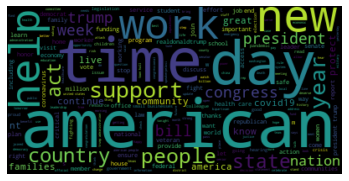

In [21]:
# plot WordCloud(ALL)

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [22]:
#Table - political party-Republicans

congress_tweets_R = congress_tweets[(congress_tweets['party']=='Republican')]
print("Shape of current df:", congress_tweets_R.shape)
congress_tweets_R.head()

Shape of current df: (3388, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
2,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744","[scipio, jones, fight, civil, rights, equality..."
4,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[understand, va, problems, recruiting, qualifi..."
5,1.305350e+18,JohnCornyn,2020-09-13T23:23:09-04:00,RT @Johnson4Dallas This is the most accurate d...,John Cornyn,Sen,2-Dec-02,2/2/1952,M,TX,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[johnson4dallas, accurate, description, curren..."
7,1.261460e+18,MikeKellyPA,2020-05-15T20:40:07-04:00,RT @HouseGOP The House is voting on legislatio...,Mike Kelly,Rep,3-Jan-11,5/10/1948,M,PA,16,Republican,"2,970,733","2,926,441","2,990,274","2,680,434","[housegop, house, voting, legislation, masks, ..."
9,1.308800e+18,RepSteveChabot,2020-09-23T12:02:58-04:00,"That common sense approach is needed now, more...",Steve Chabot,Rep,3-Jan-11,1/22/1953,M,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[common, sense, approach, needed, mom, pop, sh..."


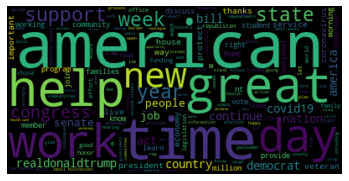

In [23]:
#WordCloud for Republicans

# Convert list of tokens back to text string
text_R = ' '.join(congress_tweets_R['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_R) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [24]:
#Table - political party-Democrats

congress_tweets_D = congress_tweets[(congress_tweets['party']=='Democrat')]
print("Shape of current df:", congress_tweets_D.shape)
congress_tweets_D.head()

Shape of current df: (6039, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. QT ...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[testifying, mr, blake, jrblake, repvaldemings..."
1,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688","[twitter, town, hall, healthcare, begun, m, an..."
3,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[better, time, actonclimate, earthday, role, p..."
6,1.302610e+18,RepTimRyan,2020-09-06T10:09:00-04:00,"Instead of solving the problem with us, the Pr...",Tim Ryan,Rep,3-Jan-03,7/16/1973,M,OH,13,Democrat,"2,841,005","2,394,164","2,827,709","2,661,437","[instead, solving, problem, president, kicked,..."
8,1.105550e+18,RepDonBeyer,2019-03-12T15:17:24-04:00,"If this is what he calls ""winning"" then yes, I...",Don Beyer,Rep,3-Jan-15,6/20/1950,M,VA,8,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[calls, winning, yes, tired, voxdotcom, trump,..."


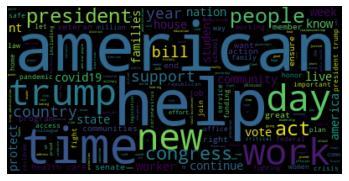

In [25]:
##WordCloud for Democrats
# Convert list of tokens back to text string
text_D = ' '.join(congress_tweets_D['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_D) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [26]:
#Table - Legislator position-Senator

congress_tweets_sen = congress_tweets[congress_tweets["position"]=="Sen"]
print("Shape of current df:", congress_tweets_sen.shape)
congress_tweets_sen.head()

Shape of current df: (2191, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
5,1.305350e+18,JohnCornyn,2020-09-13T23:23:09-04:00,RT @Johnson4Dallas This is the most accurate d...,John Cornyn,Sen,2-Dec-02,2/2/1952,M,TX,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[johnson4dallas, accurate, description, curren..."
13,1.319420e+18,SenDanSullivan,2020-10-22T19:13:06-04:00,"Iran &amp; Russia, as expected, are trying to ...",Dan Sullivan,Sen,3-Jan-15,11/13/1964,M,AK,Senate,Republican,"163,387","116,454","122,640","164,676","[iran, russia, expected, trying, undermine, de..."
18,1.152240e+18,SenKevinCramer,2019-07-19T11:30:14-04:00,Right now Spirit Lake effectively holds jurisd...,Kevin Cramer,Sen,3-Jan-19,1/21/1961,M,ND,Senate,Republican,"216,794","93,758","124,827","188,163","[right, spirit, lake, effectively, holds, juri..."
23,1.237820e+18,SenToomey,2020-03-11T15:16:42-04:00,RT @Heritage LIVE: @SenToomey is here with us ...,Pat Toomey,Sen,3-Jan-11,11/17/1961,M,PA,Senate,Republican,"2,970,733","2,926,441","2,990,274","2,680,434","[heritage, live, sentoomey, —, speaking, capit..."
26,1.131620e+18,MikeCrapo,2019-05-23T13:45:55-04:00,RT @SenJohnThune Glad my bipartisan bill to he...,Mike Crapo,Sen,3-Jan-99,5/20/1951,M,ID,Senate,Republican,"409,055","189,765","212,787","420,911","[senjohnthune, glad, bipartisan, bill, help, s..."


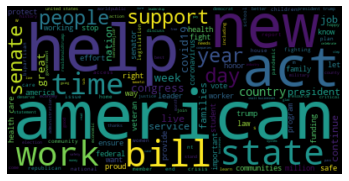

In [27]:
##WordCloud for Senators
# Convert list of tokens back to text string
text_sen = ' '.join(congress_tweets_sen['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_sen) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [28]:
#Table - Legislator position- House of Representatives 

congress_tweets_hrep = congress_tweets[congress_tweets["position"]=="Rep"]
print("Shape of current df:", congress_tweets_hrep.shape)
congress_tweets_hrep.head()

Shape of current df: (7236, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. QT ...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[testifying, mr, blake, jrblake, repvaldemings..."
1,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688","[twitter, town, hall, healthcare, begun, m, an..."
2,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744","[scipio, jones, fight, civil, rights, equality..."
3,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[better, time, actonclimate, earthday, role, p..."
4,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[understand, va, problems, recruiting, qualifi..."


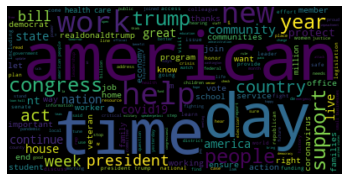

In [29]:
##WordCloud for House of Representatives
# Convert list of tokens back to text string
text_hrep = ' '.join(congress_tweets_hrep['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_hrep) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### Based on our word clouds, it appears that Republicans have a high frequency of the word “great” which makes sense given that Trump’s campaign was based on “Make America Great Again”. As for Democrats, it was interesting to find that the word “Trump” had a high frequency, which could be because they were concerned by his policies. When comparing senators and representatives, we find that senators have a high frequency of the word “help” and lower frequency of the word “american” compared to representatives. We are unsure of why this distinction exists although we find it is interesting to note.


## EDA 2. Topic modeling 

In [30]:
# add column where tokens are concatenated into a single string
congress_tweets['tokens_str'] = congress_tweets['tokens'].str.join(" ")
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_str
0,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. QT ...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[testifying, mr, blake, jrblake, repvaldemings...",testifying mr blake jrblake repvaldemings gave...
1,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688","[twitter, town, hall, healthcare, begun, m, an...",twitter town hall healthcare begun m answering...
2,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744","[scipio, jones, fight, civil, rights, equality...",scipio jones fight civil rights equality impor...
3,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[better, time, actonclimate, earthday, role, p...",better time actonclimate earthday role play pr...
4,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[understand, va, problems, recruiting, qualifi...",understand va problems recruiting qualified ph...


In [31]:
#create tf-idf matrix
X = congress_tweets['tokens_str']
tf = TfidfVectorizer() #creating an object : tf model

tfidf_matrix =  tf.fit_transform(X) #downweigh the common words & upweigh the rare words
dense_matrix = tfidf_matrix.todense() #remove all the columns where there are 0's

In [32]:
tfidf_matrix

<9427x27971 sparse matrix of type '<class 'numpy.float64'>'
	with 173710 stored elements in Compressed Sparse Row format>

In [33]:
dense_matrix

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
#initialize model/ prespecify the parameter n => "10 topics"
lda = LatentDirichletAllocation(n_components=10, max_iter=20, random_state=0) #random_state for reproducibility
lda = lda.fit(dense_matrix) # pass through our dense matrix

/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [35]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [36]:
#prints out top words using different objects attached to our lda model
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:
aca preexisting court deadline protectourcare barrett lawsuit articles judge apply supreme getcovered scotus constitution nominee amy coney facts nomination inquiry

Topic #1:
la weekly file communist lwcf el turkey de deadline michaelcburgess crucial miss en extended fridayswithfrank sacrifices billing chesapeake update inquiry

Topic #2:
de paycheckprotectionprogram kong hong smart weapons en art sba concerned countless el fakeemergency repmcgovern houseforeigngop ccp advocate terminate huawei congratulations

Topic #3:
counted easier facts civilian effect frontlines faced fathersday middle decisions concerned de red flu officially minority recover powers partners signs

Topic #4:
cummings happy elijah urgently parks park afghanistan halloween devos deliver repbarbaralee guns congratulations indian districts miss fewer teacher dire betsy

Topic #5:
miners patriotic washing smallbusinesssaturday prayer pm veteransday en bernie hide acosta repchiproy deputy citizensunited at

/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [37]:
#get the topic distribution array
topic_dist = lda.transform(tfidf_matrix)
topic_dist

array([[0.02032211, 0.22137503, 0.02032211, ..., 0.61604057, 0.020323  ,
        0.02032211],
       [0.02441311, 0.11676899, 0.02441337, ..., 0.68792746, 0.02441353,
        0.02441232],
       [0.01845225, 0.01845108, 0.19221829, ..., 0.66017123, 0.01845099,
        0.01845133],
       ...,
       [0.02048851, 0.02048851, 0.02048851, ..., 0.75107845, 0.08500896,
        0.02049   ],
       [0.02915666, 0.73756839, 0.02916452, ..., 0.02916421, 0.02915588,
        0.02915715],
       [0.02067574, 0.02067523, 0.02067538, ..., 0.60024738, 0.02067499,
        0.23434953]])

In [38]:
#merge back with original dataframe
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(congress_tweets.reset_index())
df_w_topics.head()

,0,1,2,3,4,5,6,7,8,9,...,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_str
0,0.020322,0.221375,0.020322,0.020327,0.020324,0.020322,0.020322,0.616041,0.020323,0.020322,...,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[testifying, mr, blake, jrblake, repvaldemings...",testifying mr blake jrblake repvaldemings gave...
1,0.024413,0.116769,0.024413,0.024413,0.024412,0.024413,0.024413,0.687927,0.024414,0.024412,...,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688","[twitter, town, hall, healthcare, begun, m, an...",twitter town hall healthcare begun m answering...
2,0.018452,0.018451,0.192218,0.018451,0.018451,0.018451,0.018451,0.660171,0.018451,0.018451,...,M,AR,2,Republican,"684,872","380,494","394,409","647,744","[scipio, jones, fight, civil, rights, equality...",scipio jones fight civil rights equality impor...
3,0.023583,0.023583,0.023583,0.023583,0.023583,0.023583,0.023584,0.787749,0.023583,0.023583,...,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[better, time, actonclimate, earthday, role, p...",better time actonclimate earthday role play pr...
4,0.324153,0.021191,0.021184,0.021189,0.021185,0.021183,0.021183,0.506365,0.021185,0.021183,...,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[understand, va, problems, recruiting, qualifi...",understand va problems recruiting qualified ph...


In [39]:
#check the average weight of each topic across "party" using groupby
grouped = df_w_topics.groupby('party')
for i in range(0, 10):
    print(grouped[i].mean().sort_values(ascending=False))

party
Republican    0.058139
Democrat      0.052730
Name: 0, dtype: float64
party
Republican    0.048416
Democrat      0.045175
Name: 1, dtype: float64
party
Republican    0.052064
Democrat      0.046422
Name: 2, dtype: float64
party
Republican    0.049621
Democrat      0.047532
Name: 3, dtype: float64
party
Republican    0.046241
Democrat      0.045380
Name: 4, dtype: float64
party
Republican    0.047907
Democrat      0.044646
Name: 5, dtype: float64
party
Republican    0.059141
Democrat      0.054201
Name: 6, dtype: float64
party
Democrat      0.571693
Republican    0.542058
Name: 7, dtype: float64
party
Republican    0.047859
Democrat      0.044340
Name: 8, dtype: float64
party
Republican    0.048553
Democrat      0.047882
Name: 9, dtype: float64


In [40]:
#check the average weight of each topic across "position" using groupby
grouped2 = df_w_topics.groupby('position')
for i in range(0, 10):
    print(grouped2[i].mean().sort_values(ascending=False))

position
Sen    0.055148
Rep    0.054530
Name: 0, dtype: float64
position
Rep    0.047571
Sen    0.042273
Name: 1, dtype: float64
position
Rep    0.049432
Sen    0.045206
Name: 2, dtype: float64
position
Rep    0.048587
Sen    0.047278
Name: 3, dtype: float64
position
Sen    0.049676
Rep    0.044482
Name: 4, dtype: float64
position
Sen    0.046712
Rep    0.045547
Name: 5, dtype: float64
position
Rep    0.056382
Sen    0.054637
Name: 6, dtype: float64
position
Sen    0.566366
Rep    0.559431
Name: 7, dtype: float64
position
Rep    0.046126
Sen    0.043882
Name: 8, dtype: float64
position
Sen    0.048822
Rep    0.047912
Name: 9, dtype: float64


## Overall, the 10 topics do not appear to have a lot of separation between democrats and republicans, as well as, senators and representatives. However, for Democrats and Republicans, topics 0 and 4 have the largest separation which we will visualize below. Furthermore, for senators and representatives, topics 3 and 7 have the largest separation which we will also visualize below.

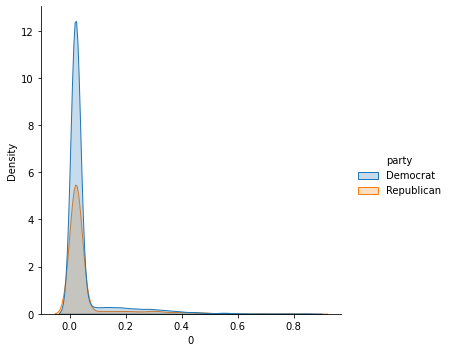

In [41]:
# Visualization- Topic 0 - for party 
sns.displot(df_w_topics, x=df_w_topics[0], hue = "party", kind = 'kde', fill = 'true')
plt.show()

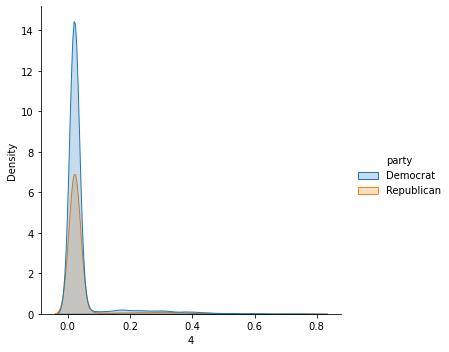

In [42]:
# Visualization- Topic 4 - for party 
sns.displot(df_w_topics, x=df_w_topics[4], hue = "party", kind = 'kde', fill = 'true')
plt.show()

## For both topics 0 and 4, it appears that Republicans discuss them more than Democrats. Looking at the words in each topic above, topic 0 seems to discuss help surrounding COVID-19 and topic 4 mentions Trump, realdonaldtrump, (his twitter handle), and impeachment several times. The latter makes sense as a Republican topic. 

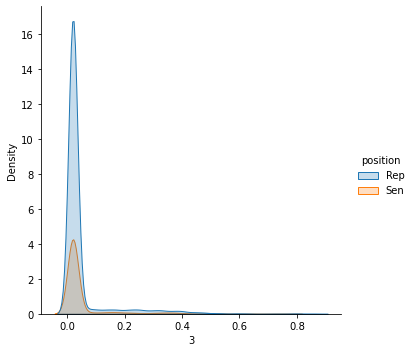

In [43]:
# Visualization- Topic 3 - for position
sns.displot(df_w_topics, x=df_w_topics[3], hue = "position", kind = 'kde', fill = 'true')
plt.show()

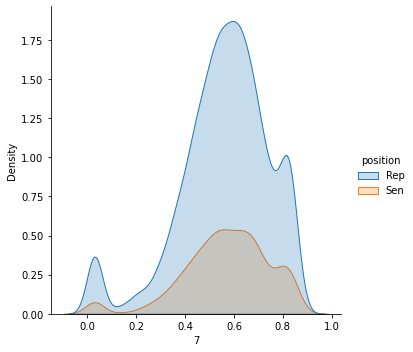

In [44]:
# Visualization- Topic 7 - for position
sns.displot(df_w_topics, x=df_w_topics[7], hue = "position", kind = 'kde', fill = 'true')
plt.show()

## For both topics 3 and 7, the visualizations show that representatives discuss them more heavily than senators, however looking at the words in each topic above does not help us understand the distinction. 

## Overall, the visualizations show that the topics would NOT be good candidates to pass to a supervised learning algorithm if we were interested in predicting the party (Democrats/Republicans) or position(senate/representative). 

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

## 1) Exploration: Overall

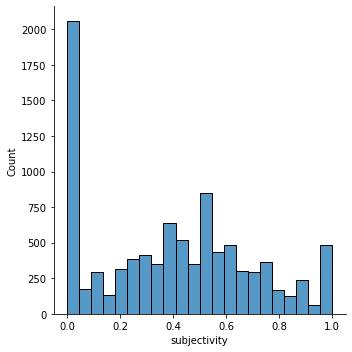

In [45]:
#check subjectivity for all tweets 
congress_tweets['subjectivity'] = congress_tweets['tokens_str'].map(lambda text: TextBlob(text).sentiment.subjectivity)
sns.displot(congress_tweets, x="subjectivity")
plt.show()

## Subjective sentences generally refer to personal opinion, emotion or judgment (=1) whereas objective refers to factual information (=0). Although the overall distribution is relatively normal, there is a much higher count of lower subjectivity tweets (0) compared to higher subjectivity tweets (1). 

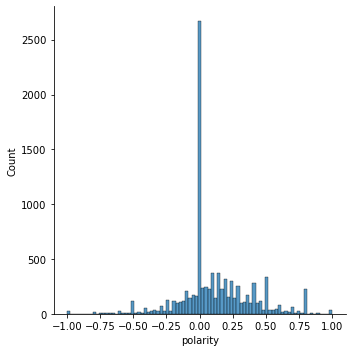

In [46]:
#check sentiment/polarity for all tweets 
congress_tweets['polarity'] = congress_tweets['tokens_str'].map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(congress_tweets, x="polarity")
plt.show()

## Polarity refers to sentiment with 1 meaning a positive sentiment and -1 meaning a negative sentiment and 0 meaning a neutral sentiment. The visualization demonstrates an overall neutral sentiment with more counts leaning towards positive sentiment. 

## 2) Choose two legislators, one liberal and one conservative

In [47]:
# get list of Republican tweets
congress_tweets_R.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
2,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744","[scipio, jones, fight, civil, rights, equality..."
4,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[understand, va, problems, recruiting, qualifi..."
5,1.305350e+18,JohnCornyn,2020-09-13T23:23:09-04:00,RT @Johnson4Dallas This is the most accurate d...,John Cornyn,Sen,2-Dec-02,2/2/1952,M,TX,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[johnson4dallas, accurate, description, curren..."
7,1.261460e+18,MikeKellyPA,2020-05-15T20:40:07-04:00,RT @HouseGOP The House is voting on legislatio...,Mike Kelly,Rep,3-Jan-11,5/10/1948,M,PA,16,Republican,"2,970,733","2,926,441","2,990,274","2,680,434","[housegop, house, voting, legislation, masks, ..."
9,1.308800e+18,RepSteveChabot,2020-09-23T12:02:58-04:00,"That common sense approach is needed now, more...",Steve Chabot,Rep,3-Jan-11,1/22/1953,M,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[common, sense, approach, needed, mom, pop, sh..."


In [48]:
# select David Joyce
congress_tweets_DavidJoyce = congress_tweets[congress_tweets["name_wikipedia"]=="David Joyce"].copy()
congress_tweets_DavidJoyce

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_str,subjectivity,polarity
1625,1.191390e+18,RepDaveJoyce,2019-11-04T11:35:54-05:00,Did you know that there are 2+ million veteran...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[know, 2, million, veteranowned, businesses, n...",know 2 million veteranowned businesses nationw...,0.083333,0.183333
1746,1.329810e+18,RepDaveJoyce,2020-11-20T10:39:14-05:00,"This week, I was humbled to speak on the House...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[week, humbled, speak, house, floor, request, ...",week humbled speak house floor request chamber...,0.000000,0.000000
1910,1.274050e+18,RepDaveJoyce,2020-06-19T14:52:12-04:00,RT @Laketran Great teamwork helped to feed 450...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[laketran, great, teamwork, helped, feed, 450,...",laketran great teamwork helped feed 450 senior...,0.750000,0.800000
1929,1.216800e+18,RepDaveJoyce,2020-01-13T14:18:00-05:00,"That's why earlier this Congress, I voted for ...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[s, earlier, congress, voted, trafficking, vic...",s earlier congress voted trafficking victims a...,0.500000,0.000000
2493,1.141780e+18,RepDaveJoyce,2019-06-20T14:46:35-04:00,So glad @MentorHigh's Nadia Bauman - who won 2...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[glad, mentorhighs, nadia, bauman, won, 2nd, p...",glad mentorhighs nadia bauman won 2nd place oh...,0.666667,0.433333
2631,1.258790e+18,RepDaveJoyce,2020-05-08T12:23:57-04:00,RT @GovMikeDeWine Join the campaign to #LightO...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[govmikedewine, join, campaign, lightohioblue,...",govmikedewine join campaign lightohioblue supp...,0.400000,0.200000
4131,1.304400e+18,RepDaveJoyce,2020-09-11T08:23:21-04:00,Please join me in praying for all the families...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[join, praying, families, live, day, memory, l...",join praying families live day memory lost lov...,0.650000,0.418182
4315,1.176160e+18,RepDaveJoyce,2019-09-23T11:25:50-04:00,Proud of the young men &amp; women who came to...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[proud, young, men, women, came, oh14, service...",proud young men women came oh14 service academ...,0.566667,0.633333
4799,1.252290e+18,RepDaveJoyce,2020-04-20T13:44:44-04:00,RT @GCPartnership Another #Cleveland business ...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[gcpartnership, cleveland, business, story, ma...",gcpartnership cleveland business story making ...,0.000000,0.000000
6133,1.230160e+18,RepDaveJoyce,2020-02-19T11:08:44-05:00,.@AWTRoboBots does great work helping students...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[awtrobobots, great, work, helping, students, ...",awtrobobots great work helping students parent...,0.625000,0.266667


In [49]:
#average subjectivity for David Joyce tweets
congress_tweets_DavidJoyce_meanS = congress_tweets_DavidJoyce["subjectivity"].mean()
print(congress_tweets_DavidJoyce_meanS)

0.4350735294117647


In [50]:
#average polarity for David Joyce tweets
congress_tweets_DavidJoyce_meanP = congress_tweets_DavidJoyce["polarity"].mean()
print(congress_tweets_DavidJoyce_meanP)

0.2909959893048128


## The overall subjectivity score for David Joyce(Republican) is 0.24 and the overall polarity score is 0.15 


In [51]:
# get list of Democrat tweets
congress_tweets_D.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. QT ...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[testifying, mr, blake, jrblake, repvaldemings..."
1,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688","[twitter, town, hall, healthcare, begun, m, an..."
3,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[better, time, actonclimate, earthday, role, p..."
6,1.302610e+18,RepTimRyan,2020-09-06T10:09:00-04:00,"Instead of solving the problem with us, the Pr...",Tim Ryan,Rep,3-Jan-03,7/16/1973,M,OH,13,Democrat,"2,841,005","2,394,164","2,827,709","2,661,437","[instead, solving, problem, president, kicked,..."
8,1.105550e+18,RepDonBeyer,2019-03-12T15:17:24-04:00,"If this is what he calls ""winning"" then yes, I...",Don Beyer,Rep,3-Jan-15,6/20/1950,M,VA,8,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[calls, winning, yes, tired, voxdotcom, trump,..."


In [52]:
# select Josh Harder
congress_tweets_JoshHarder = congress_tweets[congress_tweets["name_wikipedia"]=="Josh Harder"].copy()
congress_tweets_JoshHarder

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_str,subjectivity,polarity
116,1.174500e+18,RepJoshHarder,2019-09-18T21:45:00-04:00,Great to meet with students enrolled in Patter...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[great, meet, students, enrolled, patterson, h...",great meet students enrolled patterson high ca...,0.481429,0.311429
652,1.109260e+18,RepJoshHarder,2019-03-22T21:00:00-04:00,Thanks Kathy. Still have lots of work to do.,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[thanks, kathy, lots, work]",thanks kathy lots work,0.200000,0.200000
679,1.133890e+18,RepJoshHarder,2019-05-29T20:15:00-04:00,This Memorial Day I attended three powerful ev...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[memorial, day, attended, powerful, events, re...",memorial day attended powerful events remember...,0.625000,0.150000
721,1.163620e+18,RepJoshHarder,2019-08-19T21:00:00-04:00,As housing prices skyrocket in the Valley far ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[housing, prices, skyrocket, valley, far, folk...",housing prices skyrocket valley far folks scra...,0.550000,0.050000
2076,1.179940e+18,RepJoshHarder,2019-10-03T21:45:00-04:00,Thanks to the City Ministry Network for inviti...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[thanks, city, ministry, network, inviting, jo...",thanks city ministry network inviting join cat...,0.487500,0.409091
2093,1.116720e+18,RepJoshHarder,2019-04-12T11:14:11-04:00,Correct. QT @nowthisnews Betsy DeVos plans to...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[correct, nowthisnews, betsy, devos, plans, cu...",correct nowthisnews betsy devos plans cut spen...,0.000000,0.000000
2778,1.241120e+18,RepJoshHarder,2020-03-20T18:03:38-04:00,1.Isolation masks2.Hand sanitizer – 60% and gr...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[1isolation, masks2hand, sanitizer, 60, greate...",1isolation masks2hand sanitizer 60 greater alc...,0.309524,0.238095
2779,1.275130e+18,RepJoshHarder,2020-06-22T14:00:00-04:00,Coronavirus hospitalizations in California hi...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[coronavirus, hospitalizations, california, hi...",coronavirus hospitalizations california hit al...,0.680000,0.253333
2833,1.215760e+18,RepJoshHarder,2020-01-10T17:02:26-05:00,"Every day I wake up, I appreciate the trust th...",Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[day, wake, appreciate, trust, people, valley,...",day wake appreciate trust people valley repres...,0.875000,0.600000
3267,1.114290e+18,RepJoshHarder,2019-04-05T18:00:00-04:00,"Great to meet with folks from Patterson, Mante...",Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[great, meet, folks, patterson, manteca, ripon...",great meet folks patterson manteca ripon yeste...,0.475000,0.500000


In [53]:
#average subjectivity for Josh Harder tweets
congress_tweets_JoshHarder_meanS = congress_tweets_JoshHarder["subjectivity"].mean()
print(congress_tweets_JoshHarder_meanS)

0.3704290043290044


In [54]:
#average polarity for Josh Harder tweets
congress_tweets_JoshHarder_meanP = congress_tweets_JoshHarder["polarity"].mean()
print(congress_tweets_JoshHarder_meanP)

0.12353852813852816


## The overall subjectivity score for Josh Harder (Democrat) is 0.46 and the overall polarity score is 0.21. Compared to David Joyce, Josh Harder has both a higher subjectivity (less objective) and higher polarity (more positive sentiment). 

## 3-1)  compare Democrats v. Republicans 

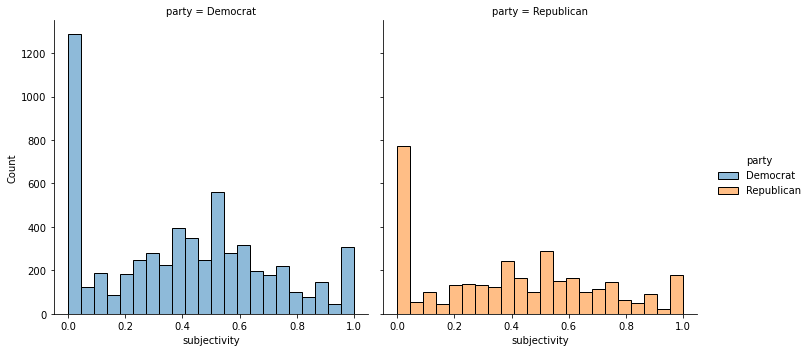

In [55]:
sns.displot(congress_tweets, x="subjectivity", hue = "party", col = "party")
plt.show()

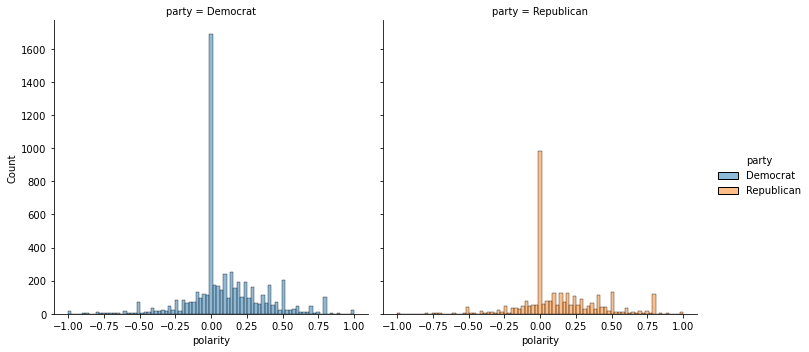

In [56]:
sns.displot(congress_tweets, x="polarity", hue = "party", col = "party")
plt.show()

## Overall, Democrats (party 0) have higher neutral subjectivity (=0) and higher neutral sentiment (polarity =0) than Republicans (party 1) meaning that the tweets they post are more objective and neutral.

## 3-2) compare Senators v. Representatives 

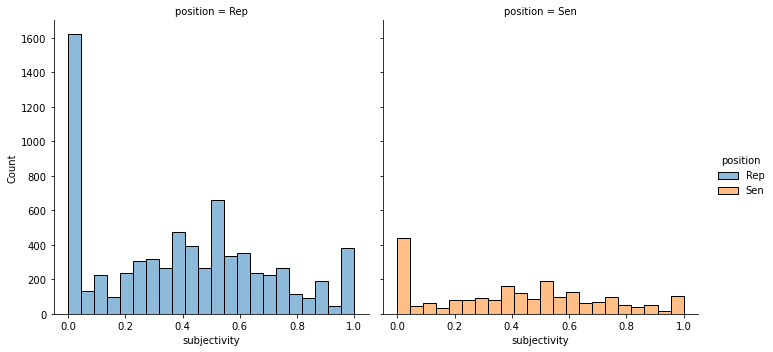

In [57]:
sns.displot(congress_tweets, x="subjectivity", hue = 'position', col = 'position')
plt.show()

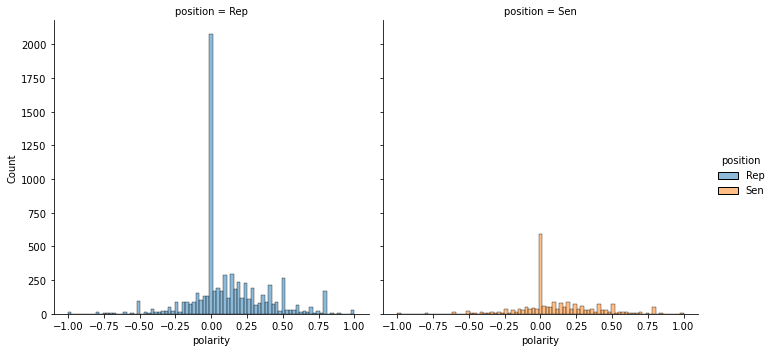

In [58]:
sns.displot(congress_tweets, x="polarity", hue = 'position', col = 'position')
plt.show()

## Overall, representatives (position 0) have higher neutral subjectivity (=0) and higher neutral sentiment (polarity = 0) than senators (position 1) meaning that the tweets they post are more objective and neutral in sentiment. 

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [59]:
congress_tweets.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'tokens_str', 'subjectivity',
       'polarity'],
      dtype='object')

### Engineered Text Features

In [60]:
# Engineered Features
engineered_features = congress_tweets[['polarity', 'subjectivity']].reset_index(drop = True)

# Topic Model + Engineered Features
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))


In [61]:
engineered_features_with_topics.head() # check first few rows of df with engineered text feats

,0,1,2,3,4,5,6,7,8,9,polarity,subjectivity
0,0.020322,0.221375,0.020322,0.020327,0.020324,0.020322,0.020322,0.616041,0.020323,0.020322,0.000000,0.000000
1,0.024413,0.116769,0.024413,0.024413,0.024412,0.024413,0.024413,0.687927,0.024414,0.024412,0.136364,0.500000
2,0.018452,0.018451,0.192218,0.018451,0.018451,0.018451,0.018451,0.660171,0.018451,0.018451,0.511111,0.833333
3,0.023583,0.023583,0.023583,0.023583,0.023583,0.023583,0.023584,0.787749,0.023583,0.023583,0.450000,0.750000
4,0.324153,0.021191,0.021184,0.021189,0.021185,0.021183,0.021183,0.506365,0.021185,0.021183,0.000000,0.000000


### Bag-of-words or Tf-idf

In [62]:
# Frequency Based featurization
X = congress_tweets['tokens_str']
tf = TfidfVectorizer()

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())

/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [63]:
tfidf_df.head()

,0001,01,0184,019119so,026,03,0312,0600pm,080,10,...,órdenes,último,últimos,únase,útil,ŧhen,ŧhere,ʻewa,языкtagalogtiếng,જર
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
X.head(30)

0     testifying mr blake jrblake repvaldemings gave...
1     twitter town hall healthcare begun m answering...
2     scipio jones fight civil rights equality impor...
3     better time actonclimate earthday role play pr...
4     understand va problems recruiting qualified ph...
5     johnson4dallas accurate description current ci...
6     instead solving problem president kicked road ...
7     housegop house voting legislation masks democr...
8     calls winning yes tired voxdotcom trump said c...
9     common sense approach needed mom pop shops ree...
10    repblumenauer told nytimes heartbreaking local...
11    repmceachin senduckworth senbooker repjayapal ...
12    mlkday reflect unique strength leadership pers...
13    iran russia expected trying undermine democrac...
14    joined secretarycarsons site visit phoenix aer...
15    intentions opportunity zones good allow progra...
16    helsinkicomm 19 chair rephastingsfl cochair se...
17    going sacrifice kids administration believ

### Word Embedding - N STOPPED HERE 

In [65]:
#Create word embedding model
model = gensim.models.Word2Vec(congress_tweets['tokens'], vector_size=100, window=3, \
                               min_count=5, sg=0, alpha=0.025, batch_words=10000)

In [66]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_str,subjectivity,polarity
0,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. QT ...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[testifying, mr, blake, jrblake, repvaldemings...",testifying mr blake jrblake repvaldemings gave...,0.000000,0.000000
1,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688","[twitter, town, hall, healthcare, begun, m, an...",twitter town hall healthcare begun m answering...,0.500000,0.136364
2,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744","[scipio, jones, fight, civil, rights, equality...",scipio jones fight civil rights equality impor...,0.833333,0.511111
3,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[better, time, actonclimate, earthday, role, p...",better time actonclimate earthday role play pr...,0.750000,0.450000
4,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[understand, va, problems, recruiting, qualifi...",understand va problems recruiting qualified ph...,0.000000,0.000000


In [67]:
#see length of first token
len(congress_tweets['tokens'][0])

16

In [68]:
#see length of first doc
doc = [word for word in congress_tweets['tokens'][0] if word in model.wv.index_to_key]
len(doc)

13

In [69]:
doc [0:5]

['testifying', 'mr', 'repvaldemings', 'gave', 'speech']

In [70]:
#grab the first vector for each token and take their mean:
first_vec = []
for token in model.wv.__getitem__(doc):
    first_vec.append(token[0])
np.mean(first_vec)

-0.21461709

In [71]:
#Define a function to average word embeddings for a document
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.index_to_key]
    return np.mean(word2vec_model.wv.__getitem__(doc), axis=0)

In [72]:
# Initialize an array for the size of the corpus
empty_list_embeddings_means = []
index_num = 0 # identify docs we can't get vector for
empty_docs = []
for doc in congress_tweets['tokens']: # append the vector for each document
    doc = [word for word in doc if word in model.wv.index_to_key]
    if len(doc)<1:
        empty_docs.append(index_num) # collect index for docs we can't get vector for -- used later in classification
        continue
    empty_list_embeddings_means.append(document_vector(model, doc))
    index_num += 1
doc_average_embeddings = np.array(empty_list_embeddings_means) # list to array

In [73]:
#average embeddings for each document 
doc_average_embeddings

array([[-0.2146171 ,  0.32700306,  0.10462357, ..., -0.28104728,
         0.09592987,  0.09493731],
       [-0.22569214,  0.37084883,  0.09141088, ..., -0.31242555,
         0.12202377,  0.11509674],
       [-0.2188242 ,  0.3682366 ,  0.12716416, ..., -0.27065748,
         0.1318503 ,  0.08653806],
       ...,
       [-0.20342202,  0.34766546,  0.10020632, ..., -0.29371348,
         0.13505709,  0.07756146],
       [-0.08606776,  0.13008472,  0.036303  , ..., -0.11572414,
         0.04698557,  0.036306  ],
       [-0.19320193,  0.32126948,  0.1045968 , ..., -0.26856056,
         0.11402614,  0.08359762]], dtype=float32)

In [74]:
#check the shape of the average document embeddings 
doc_average_embeddings.shape

(9397, 100)

In [75]:
#create dataframe
word2vec_features_df = pd.DataFrame(doc_average_embeddings) 
word2vec_features_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.214617,0.327003,0.104624,0.068232,0.060463,-0.528961,0.095133,0.707658,-0.173735,-0.027790,...,0.358562,0.115139,0.098646,0.075053,0.443835,0.236660,0.190474,-0.281047,0.095930,0.094937
1,-0.225692,0.370849,0.091411,0.084569,0.058863,-0.581849,0.113201,0.787294,-0.196965,-0.025333,...,0.385329,0.131556,0.095923,0.104152,0.483557,0.257106,0.214558,-0.312426,0.122024,0.115097
2,-0.218824,0.368237,0.127164,0.042057,0.088231,-0.585449,0.111510,0.782715,-0.226649,-0.030162,...,0.429425,0.121627,0.125665,0.071183,0.489185,0.251327,0.236227,-0.270657,0.131850,0.086538
3,-0.186263,0.306566,0.089677,0.055596,0.047637,-0.470840,0.098055,0.629185,-0.171116,-0.045036,...,0.328432,0.114207,0.073785,0.081980,0.397913,0.211993,0.175778,-0.247528,0.104155,0.076955
4,-0.177841,0.313711,0.091251,0.048971,0.043893,-0.490907,0.119343,0.653995,-0.193094,-0.048738,...,0.356382,0.124563,0.073251,0.090535,0.417811,0.217185,0.186650,-0.250725,0.127880,0.078239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9392,-0.232474,0.385718,0.106877,0.073614,0.019653,-0.579927,0.141742,0.754749,-0.204946,-0.089294,...,0.406475,0.152417,0.051329,0.123758,0.478617,0.269418,0.204517,-0.316164,0.143794,0.096943
9393,-0.253613,0.390571,0.124900,0.088510,0.081183,-0.622163,0.091913,0.839889,-0.207218,-0.023008,...,0.423690,0.131019,0.116003,0.093813,0.517313,0.290084,0.220754,-0.327639,0.096327,0.115065
9394,-0.203422,0.347665,0.100206,0.049882,0.021603,-0.530144,0.132999,0.698689,-0.197175,-0.096169,...,0.369857,0.147727,0.048845,0.118598,0.441876,0.248609,0.188727,-0.293713,0.135057,0.077561
9395,-0.086068,0.130085,0.036303,0.029114,0.020387,-0.212709,0.033835,0.290414,-0.075098,-0.012535,...,0.139567,0.043985,0.032163,0.031835,0.178271,0.095507,0.068405,-0.115724,0.046986,0.036306


## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [76]:
# collect the labels for party and chamber membership

lb_style = LabelBinarizer()
y_party = congress_tweets['party'] = lb_style.fit_transform(congress_tweets['party'])
    #0=Democrat and 1=Republican
y_chamber = congress_tweets['position'] =lb_style.fit_transform(congress_tweets['position'])
    #0=House of Rep and 1=Senate

### 1. Engineered features

#### 1.1 classify party

In [77]:
# split the data into training and test sets
X_ef_p_train, X_ef_p_test, y_p_train, y_p_test = train_test_split(engineered_features_with_topics,
                                                                  y_party,
                                                                  stratify=y_party,
                                                                  train_size = 0.80,
                                                                  test_size= 0.20,
                                                                  random_state = 10)

In [78]:
# sanity check
print(X_ef_p_train.shape)
print(y_p_train.shape)
print(X_ef_p_test.shape)
print(y_p_test.shape)

(7541, 12)
(7541, 1)
(1886, 12)
(1886, 1)


In [79]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_ef_p_train, y_p_train.ravel())

# create pedictions
y_p_pred = logit_model.predict(X_ef_p_test)

# create confusion matrix
cf_matrix_p = confusion_matrix(y_p_test, y_p_pred, normalize = "true")

/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


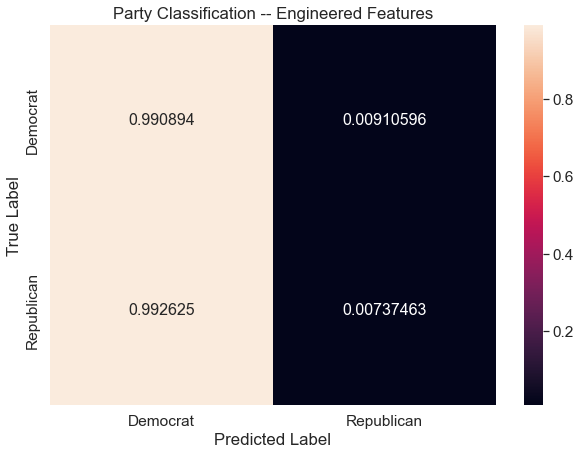

In [80]:
# display confusion matrix

df_cm = pd.DataFrame(cf_matrix_p, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm.index = ["Democrat", "Republican"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Party Classification -- Engineered Features")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [81]:
#EG: The model is not giving us great pedictions. I think it has to do with the fact that we used the topics
# for only the House of Rep in the engineered_features_with_topics. We'll have to fix that to test the model again.
#NE: the model is still not giving a great prediction for republicans... 

#### 1.2 classify chamber

In [82]:
# split the data into training and test sets
X_ef_c_train, X_ef_c_test, y_c_train, y_c_test = train_test_split(engineered_features_with_topics,
                                                                  y_chamber,
                                                                  stratify=y_chamber,
                                                                  train_size = 0.80,
                                                                  test_size=0.20,
                                                                  random_state = 10)

In [83]:
# sanity check
print(X_ef_c_train.shape)
print(y_c_train.shape)
print(X_ef_c_test.shape)
print(y_c_test.shape)

(7541, 12)
(7541, 1)
(1886, 12)
(1886, 1)


In [84]:
# create a model
logit_reg = LogisticRegression(class_weight = 'balanced')

# fit the model
logit_model = logit_reg.fit(X_ef_c_train, y_c_train.ravel())

# create pedictions
y_c_pred = logit_model.predict(X_ef_c_test)

# create confusion matrix
cf_matrix_c = confusion_matrix(y_c_test, y_c_pred, normalize = "true")

/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


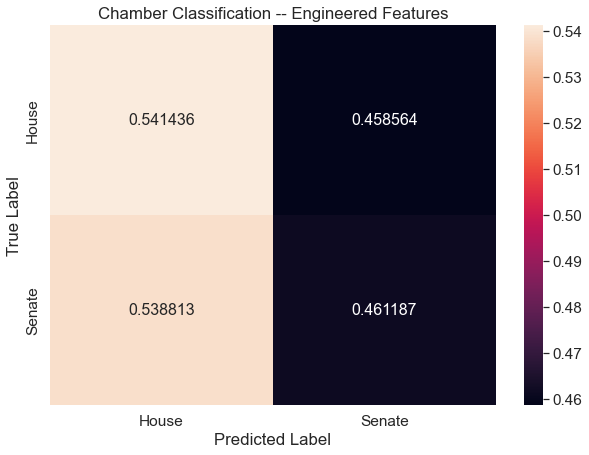

In [85]:
# display confusion matrix

df_cm = pd.DataFrame(cf_matrix_c, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "House", 1: "Senate"})
df_cm.index = ["House", "Senate"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Chamber Classification -- Engineered Features")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [86]:
#EG: this Logistic model works great, but this is only because the df only contains topics related to House of Rep.
# so the data was biased since the beginning.
#NE: this is also showing a terrible prediction 

### 2. tf-idf

#### 2.1 classify party

In [87]:
# split the data into training and test sets
X_tfidf_p_train, X_tfidf_p_test, y_p_train, y_p_test = train_test_split(tfidf_df,
                                                                        y_party,
                                                                        stratify=y_party,
                                                                        train_size = 0.80,
                                                                        test_size=0.20,
                                                                        random_state = 10)

In [88]:
# sanity check
print(X_tfidf_p_train.shape)
print(y_p_train.shape)
print(X_tfidf_p_test.shape)
print(y_p_test.shape)

(7541, 27971)
(7541, 1)
(1886, 27971)
(1886, 1)


In [89]:
# create a model
logit_reg = LogisticRegression(class_weight = 'balanced')

# fit the model
logit_model = logit_reg.fit(X_tfidf_p_train, y_p_train.ravel())

# create pedictions
y_p_pred = logit_model.predict(X_tfidf_p_test)

# create confusion matrix
cf_matrix_p = confusion_matrix(y_p_test, y_p_pred, normalize = "true")

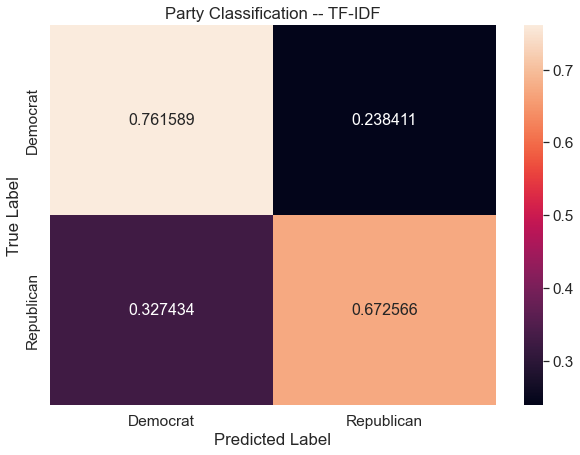

In [90]:
# display confusion matrix

df_cm = pd.DataFrame(cf_matrix_p, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm.index = ["Democrat", "Republican"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Party Classification -- TF-IDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### 2.2 classify chamber

In [91]:
# split the data into training and test sets
X_tfidf_c_train, X_tfidf_c_test, y_c_train, y_c_test = train_test_split(tfidf_df,
                                                                        y_chamber,
                                                                        stratify=y_chamber,
                                                                        train_size = 0.80,
                                                                        test_size=0.20,
                                                                        random_state = 10)

In [92]:
# sanity check
print(X_tfidf_c_train.shape)
print(y_c_train.shape)
print(X_tfidf_c_test.shape)
print(y_c_test.shape)

(7541, 27971)
(7541, 1)
(1886, 27971)
(1886, 1)


In [93]:
# create a model
logit_reg = LogisticRegression(class_weight = 'balanced')

# fit the model
logit_model = logit_reg.fit(X_tfidf_c_train, y_c_train.ravel())

# create pedictions
y_c_pred = logit_model.predict(X_tfidf_c_test)

# create confusion matrix
cf_matrix_c = confusion_matrix(y_c_test, y_c_pred, normalize = "true")

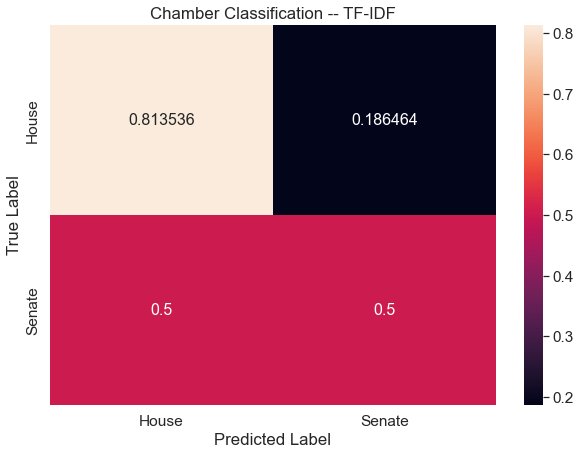

In [94]:
# display confusion matrix

df_cm = pd.DataFrame(cf_matrix_c, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "House", 1: "Senate"})
df_cm.index = ["House", "Senate"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Chamber Classification -- TF-IDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [95]:
#EG: in general, tf-idf is better for Hourse of Rep than senate. 
# I'm not sure why. Ideas? NE: because of the data imbalance? More reps than senators? 

### 3. Embeddings

In [96]:
# adjust length of labels y (for party and chamber) to match embedding length

print("Lenth of embeddings:",len(doc_average_embeddings))
print()

#party
emb_y_party = np.delete(y_party, empty_docs, axis=0)
print("Lenth of party labels:",len(emb_y_party))

#chamber
emb_y_chamber = np.delete(y_chamber, empty_docs, axis=0)
print("Lenth of chamber labels:",len(emb_y_chamber))

Lenth of embeddings: 9397

Lenth of party labels: 9397
Lenth of chamber labels: 9397


#### 3.1 classify party

In [97]:
X_emb_p_train, X_emb_p_test, y_p_train, y_p_test = train_test_split(doc_average_embeddings,
                                                                    emb_y_party,
                                                                    stratify=emb_y_party,
                                                                    train_size = 0.80,
                                                                    test_size=0.20,
                                                                    random_state = 10)

In [98]:
# sanity check
print(X_emb_p_train.shape)
print(y_p_train.shape)
print(X_emb_p_test.shape)
print(y_p_test.shape)

(7517, 100)
(7517, 1)
(1880, 100)
(1880, 1)


In [99]:
# create a model
logit_reg = LogisticRegression(class_weight = 'balanced')

# fit the model
logit_model = logit_reg.fit(X_emb_p_train, y_p_train.ravel())

# create pedictions
y_p_pred = logit_model.predict(X_emb_p_test)

# create confusion matrix
cf_matrix_p = confusion_matrix(y_p_test, y_p_pred, normalize = "true")

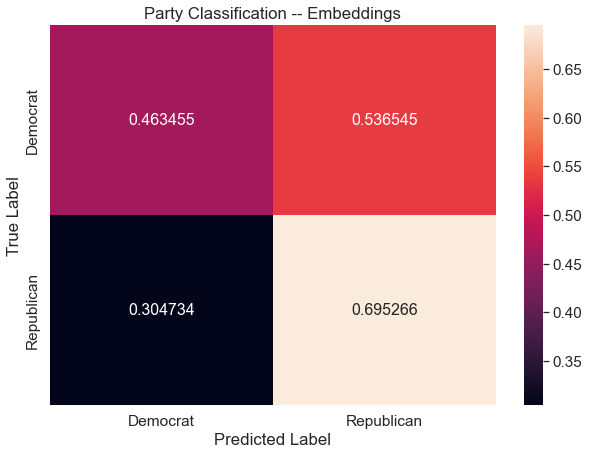

In [100]:
# display confusion matrix

df_cm = pd.DataFrame(cf_matrix_p, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm.index = ["Democrat", "Republican"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Party Classification -- Embeddings")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### 3.2 classify chamber

In [101]:
X_emb_c_train, X_emb_c_test, y_c_train, y_c_test = train_test_split(doc_average_embeddings,
                                                                    emb_y_chamber,
                                                                    stratify=emb_y_chamber,
                                                                    train_size = 0.80,
                                                                    test_size=0.20,
                                                                    random_state = 10)

In [102]:
# sanity check
print(X_emb_c_train.shape)
print(y_c_train.shape)
print(X_emb_c_test.shape)
print(y_c_test.shape)

(7517, 100)
(7517, 1)
(1880, 100)
(1880, 1)


In [103]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_emb_c_train, y_c_train.ravel())

# create pedictions
y_c_pred = logit_model.predict(X_emb_c_test)

# create confusion matrix
cf_matrix_c = confusion_matrix(y_c_test, y_c_pred, normalize = "true")

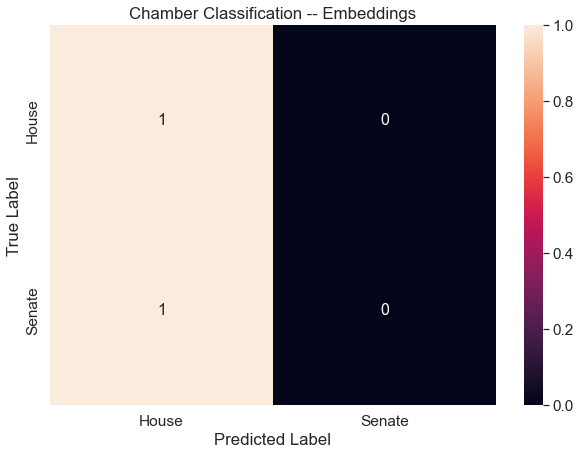

In [104]:
# display confusion matrix

df_cm = pd.DataFrame(cf_matrix_c, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "House", 1: "Senate"})
df_cm.index = ["House", "Senate"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Chamber Classification -- Embeddings")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [105]:
#EG: I don't understand why the embedding model is giving us such bad predictions for party and chamber.
# Any thoughts? Maybe you two can see something I can't.

### Two Combined Models

In [106]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**